In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})

from utilities import error, convert1D_to_2D, plot_phi,residual

In [3]:
def prepare_phi_and_S(Nx,Ny,phi,L, H, convert_to_K = False):

    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    if convert_to_K:
        S = np.zeros((Nx*Ny))
    else:   
        S = np.zeros((Nx,Ny))
    dx = L/(Nx-1)    # Grid size
    dy = H/(Ny-1)    # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy
            
            source = 50000*np.exp(-50*((1-x)**2 + y**2)) * (100*((1-x)**2+y**2) - 2)
            
            if convert_to_K:
                k = (j - 1) * Nx + i
                S[k] = source
            else:
                S[i,j] = source

    
    ## Right BC
    i = Nx-1 
    for j in range(1,Ny-1):

        x = i*dx
        y = j*dy
        phiR = 100 * (1-y) + 500*np.exp(-50*y**2)
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i,j] = phiR
            S[i,j] = phiR
        
    ## left BC
    i = 0
    for j in range(1,Ny-1):
        
        x = i*dx
        y = j*dy
        
        phiL = 500 * np.exp(-50*(1+y**2))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i,j] = phiL
            S[i,j] = phiL 

    ## Bottom BC
    j=0
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiB = 100*x + 500*np.exp(-50*(1-x)**2)
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i,j] = phiB
            S[i,j] = phiB
        

    ## Top BC
    j=Ny-1
    for i in range(Nx):
        
        x = i*dx
        y = j*dy
        
        phiT = 500 * np.exp(-50*((1-x)**2+1))
        
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i,j] = phiT
            S[i,j] = phiT

    return phi, S

In [4]:
def GS(Nx, Ny, phi, omega,S,aE,aW,aN,aS,a0, start, Rlogger):
    tol = 1e-6
    
    for _ in tqdm(range(10000)):

        for i in range(1,Nx-1):
            for j in range(1,Ny-1):

                # Gauss-Siedel Update
                phi[i,j] = omega*(S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1]) / a0 + (1-omega)*phi[i,j]

        # Calculate residual
        R2 = 0
        R = np.zeros((Nx,Ny))

        for i in range(1,Nx-1):    
            for j in range(1,Ny-1):
                R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
                R2 = R2+R[i,j]**2

        R2 = np.sqrt(R2)
        Rlogger.append(R2)
        if _ %500==0:
            clear_output(True)
            print('Residual:', R2)
            
        if R2<tol:
            print('omega: ',omega, 'Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
            break
            
    return Rlogger

In [5]:
def TRI(N,a,d,c,Q):

    # Tridiagonal matrix solver
    phi = np.zeros(N)

    # Forward Elemination
    for i in range (1,N):
        const = a[i-1] / d[i-1]
        d[i] = d[i] - const*c[i-1] # Diagonal
        Q[i] = Q[i] - const*Q[i-1]  # RHS
    
    # Solve last equation 
    phi[-1] = Q[-1]/d[-1]

    # Qackward Elemination
    for i in range(N-2,-1,-1):
        
        phi[i] = (Q[i] - c[i]*phi[i+1]) / d[i]

    return phi
    
def ADI(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[]):
    tol = 1e-6

    for _ in tqdm(range(100000)):
        
        c = np.zeros(Nx-1)
        a = np.zeros(Nx-1)
        d = np.zeros(Nx)
        Q = np.zeros(Nx)
        for j in range(1,Ny-1):

            # For Dirichlet BC
            d[0] = 1

            # Left BC
            Q[0] = phi[0,j]

            for i in range(1,Nx-1):
                # Coefficient for Tridiagonal matrix solver
                d[i] = a0
                a[i-1] = aW
                c[i] = aE
                
                # RHS for Tri matrix
                Q[i] = S[i,j] - phi[i,j+1]*aN - phi[i,j-1]*aS

            # For Dirichlet BC
            d[Nx-1]=1
            
            # Right BC
            Q[Nx-1] = phi[-1,j]
            
            # Solve for current row
            phix = TRI(Nx,a,d,c,Q)

            # Update current new row solution
            phi[:,j] = phix
        
        # Column-wise sweep
        c = np.zeros(Ny-1)
        a = np.zeros(Ny-1)
        d = np.zeros(Ny)
        Q = np.zeros(Ny)
        for i in range(1,Nx-1):

            # For Dirichlet BC
            d[0] = 1

            # Bottom BC
            Q[0] = phi[i,0]

            for j in range(1,Ny-1):
                x = i*dx
                y = j*dy

                # Coefficient for Tridiagonal matrix solver
                d[j] = a0
                a[j-1] = aN
                c[j] = aS

                # RHS for Tri matrix
                Q[j] = S[i,j] - phi[i+1,j]*aE - phi[i-1,j]*aW


            # For Dirichlet BC
            d[Ny-1]=1
            
            # Top BC
            Q[Ny-1] = phi[i,Ny-1]
            
            # Solve for current row
            phix = TRI(Ny,a,d,c,Q)

            # Update current new row solution
            phi[i,:] = phix
            
        # Calculate residual
        R2 = 0
        R = np.zeros((Nx,Ny))
        Rlogger.append(R2)
        for i in range(1,Nx-1):
            for j in range(1,Ny-1):
                R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
                R2 = R2+R[i,j]**2

        R2 = np.sqrt(R2)
        Rlogger.append(R2)
        if _ %50==0:
            clear_output(True)
            print("Residual: ",R2)
            
        if R2<tol:
            print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
            break

    return Rlogger
            

In [6]:
def stonesmethod(N, K, B, D, E, F, H):
    d, e, c, b, f = np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K)
    # Bbar,Cbar,Dbar,Ebar,Fbar,Gbar,Hbar = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    alpha = 0.8

    # Step 3
    d[0] = E[0]
    e[0] = F[0] / d[0]
    f[0] = H[0] / d[0]

    for k in range(1, K):
        if k > N:
            b[k] = B[k] / (1 + alpha * e[k - N])
        # print(k, K, c.shape)
        c[k] = D[k] / (1 + alpha * f[k - 1])

        if k > N:
            d[k] = E[k] + alpha * (b[k] * e[k - N] + c[k] * f[k - 1]) - b[k] * f[k - N] - c[k] * e[k - 1]
        else:
            d[k] = E[k] + alpha * (c[k] * f[k - 1]) - c[k] * e[k - 1]

        f[k] = (H[k] - alpha * c[k] * f[k - 1]) / d[k]

        if k > N:
            e[k] = (F[k] - alpha * b[k] * e[k - N]) / d[k]

        else:
            e[k] = F[k] / d[k]

    return b, c, d, e, f

def Stones(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[]):
    
    tol = 1e-6
    L = np.zeros((Nx ** 2, Ny ** 2))
    U = np.zeros((Nx ** 2, Ny ** 2))
    ## Right BC
    i = Nx - 1
    for j in range(1,Ny-1):
        k = (j - 1) * Nx + i
        L[k, k] = 1
        U[k, k] = 1

    ## left BC
    i = 0
    for j in range(1,Ny-1):
        k = (j - 1) * Nx + i
        L[k, k] = 1
        U[k, k] = 1
    ## Bottom BC
    j = 0
    for i in range(Nx):
        k = (j - 1) * Nx + i
        L[k, k] = 1
        U[k, k] = 1
    ## Top BC
    j = Ny - 1
    for i in range(Nx):
        k = (j - 1) * Nx + i
        L[k, k] = 1
        U[k, k] = 1

    aE = 1 / dx ** 2
    aW = 1 / dx ** 2
    aN = 1 / dy ** 2
    aS = 1 / dy ** 2
    a0 = -(2 / dx ** 2 + 2 / dy ** 2)


    # Step 
    K = Nx*Ny
    B = np.full(K, aS)
    D = np.full(K, aW)
    E = np.full(K, a0)
    F = np.full(K, aE)
    H = np.full(K, aN)

    s = time.time()
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            k = (j - 1) * Nx + i
            b, c, d, e, f = stonesmethod(Nx, k, B, D, E, F, H)

            # print(k)

            L[k, k] = d[k-1]
            L[k, k - 1] = c[k-1]
            L[k, k - Nx] = b[k-1]

            U[k, k] = 1
            U[k, k + 1] = e[k-1]
            U[k, k + Nx] = f[k-1]

    R2 = 0
    R = np.zeros(Nx*Ny)


    for _ in tqdm(range(100000)):
        # Step 4
        # Calculate residual
        R2 = 0
        for i in range(1, Nx - 1):

            for j in range(1, Ny - 1):
                x = i * dx
                y = j * dy
                k = (j - 1) * Nx + i
                R[k] = S[k] - aE * phi[k + 1] - aW * phi[k - 1] - aN * phi[k + Nx] - aS * phi[k - Nx] - a0 * phi[k]

                R2 = R2 + R[k] ** 2

        # Step 5
        Y = np.matmul(np.linalg.inv(L),R)

        # Step 6
        delta = np.matmul(np.linalg.inv(U) , Y)

        phi += delta
        # print(delta)
        R2 = np.sqrt(R2)
        Rlogger.append(R2)
        if _ % 10 == 0:
            clear_output(True)
            print("Residual: ", R2)

        if R2 < tol:
            print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
            break

    return Rlogger

In [7]:
def MSD(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[]):
    # Same coefficient name as Stone's method
    tol = 1e-6
    K = Nx*Ny
    B = np.full(K, aS)
    D = np.full(K, aW)
    E = np.full(K, a0)
    F = np.full(K, aE)
    H = np.full(K, aN)


    

    for _ in tqdm(range(100000)):
        # Step 4
        # Calculate residual
        R2sum = 0
        R = np.zeros((Nx*Ny))
        for i in range(1, Nx - 1):

            for j in range(1, Ny - 1):
                x = i * dx
                y = j * dy
                k = (j - 1) * Nx + i
                R[k] = S[k] - aE * phi[k + 1] - aW * phi[k - 1] - aN * phi[k + Nx] - aS * phi[k - Nx] - a0 * phi[k]

                R2sum = R2sum + R[k] ** 2
                
        R2 = np.sqrt(R2sum)
        
        c = np.zeros(Nx*Ny)

        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                K = (j - 1) * Nx + i
                k = K-1
                
                c[k] = E[k]*R[k] + F[k]*R[k+1] + H[k]*R[k+Nx] + D[k]*R[k-1] + B[k]*R[k-Nx]

        rtc = 0

        for k in range(Nx*Ny):
            rtc = rtc + R[k]*c[k]
        
        alpha = R2sum/rtc

        phi = phi + alpha*R
        
        Rlogger.append(R2)
        if _ % 1000 == 0:
            clear_output(True)
            print(f'alpha: {alpha}')
            print("Residual: ", R2)

        if R2 < tol:
            print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
            break
            
    return Rlogger


In [8]:
def CG(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[]):
    tol=1e-6
    # Same coefficient name as Stone's method
    K = Nx*Ny
    B = np.full(K, aS)
    D = np.full(K, aW)
    E = np.full(K, a0)
    F = np.full(K, aE)
    H = np.full(K, aN)
    # Initial residual
    R2sum_old, R = residual(Nx,Ny,phi,S,aE,aW,aN,aS,a0)
            
    R2_old = np.sqrt(R2sum_old)
    # Step 3: Set the initial search direction vector equal to the residual vector
    D0 = R

    for _ in tqdm(range(100000)):

        # Compute new alpha
        # Compute A@D
        ad = np.zeros(Nx*Ny)
        for i in range(1,Nx-1):
            for j in range(1,Ny-1):
                k = (j - 1) * Nx + i
                # k = K-1
                
                ad[k] = E[k]*D0[k] + F[k]*D0[k+1] + H[k]*D0[k+Nx] + D[k]*D0[k-1] + B[k]*D0[k-Nx]
        
        # Compute D0.T @ A @ D
        D_t_ad = 0
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):

                k = (j - 1) * Nx + i
                D_t_ad = D_t_ad + D0[k]*ad[k]
        alpha = R.T @ R / D_t_ad


        phi = phi + alpha*D0
        
        # Compute residual
        R2sum_new, R = residual(Nx,Ny,phi,S,aE,aW,aN,aS,a0)

        R2_new = np.sqrt(R2sum_new)

        beta = R2_new**2 / R2_old**2

        # Update search direction vector
        D0 = R + beta*D0
        

        # Update old residual vector
        R2_old = R2_new
        Rlogger.append(R2_new)
        if _ % 100 == 0:
            clear_output(True)
            print(f'alpha: {alpha}')
            print("Residual: ", R2_new)

        if R2_new < tol:
            print('Converged! Residual: ',R2_new, 'Time elapsed: ', time.time()-start)
            break
    return Rlogger

In [9]:
# numbering scheme used is k = (j-1)*N + i

Nx = 41
Ny = 41
L = 1   # length
H = 1   # length

S = np.zeros((Nx,Ny))
phi = np.zeros((Nx,Ny))

dx = L/(Nx-1)    # Grid size
dy = H/(Ny-1)    # Grid size

tol = 1e-3
aE = 1/dx**2
aW = 1/dx**2
aN = 1/dy**2
aS = 1/dy**2
a0 = -(2/dx**2 + 2/dy**2)

phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H)


Rlogger = []


############# GS #############
omega = 1
start = time.time()
S = np.zeros((Nx,Ny))
phi = np.zeros((Nx,Ny))
phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H)

Rlogger_GS = GS(Nx, Ny, phi, omega,S,aE,aW,aN,aS,a0, start, Rlogger)

############ ADI #############
start = time.time()
S = np.zeros((Nx,Ny))
phi = np.zeros((Nx,Ny))
phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H)

Rlogger_ADI = ADI(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[])
############# Stone's method #############
start = time.time()
S = np.zeros((Nx*Ny))
phi = np.zeros((Nx*Ny))
phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H,convert_to_K=True)

Rlogger_Stone = Stones(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[])
############# MSD #############
start = time.time()
S = np.zeros((Nx*Ny))
phi = np.zeros((Nx*Ny))
phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H,convert_to_K=True)

Rlogger_MSD = MSD(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[])
############# CG #############
start = time.time()
S = np.zeros((Nx*Ny))
phi = np.zeros((Nx*Ny))
phi, S = prepare_phi_and_S(Nx, Ny, phi, L, H,convert_to_K=True)

Rlogger_CG = CG(Nx, Ny,dx,dy, phi,S,aE,aW,aN,aS,a0, start, Rlogger=[])


  0%|          | 135/100000 [00:00<07:36, 218.71it/s]

alpha: -0.00025383720535417895
Residual:  4.791445348837004


  0%|          | 158/100000 [00:00<07:41, 216.25it/s]

Converged! Residual:  7.31030822977448e-07 Time elapsed:  0.7364943027496338


In [10]:
# # Analytical solution
# x = np.linspace(0,1,Nx)
# y = np.linspace(0,1,Ny)
# phi_A = np.zeros((Nx,Ny))
# for i in range(Nx):
#     for j in range(Ny):
        
#         phi_A[i,j] = 500*np.exp(-50*((1-x[i])**2 + y[j]**2)) + 100*x[i]*(1-y[j])

# plot_phi(phi_A, phi_A, Nx, Ny, 'GS', convert=False)






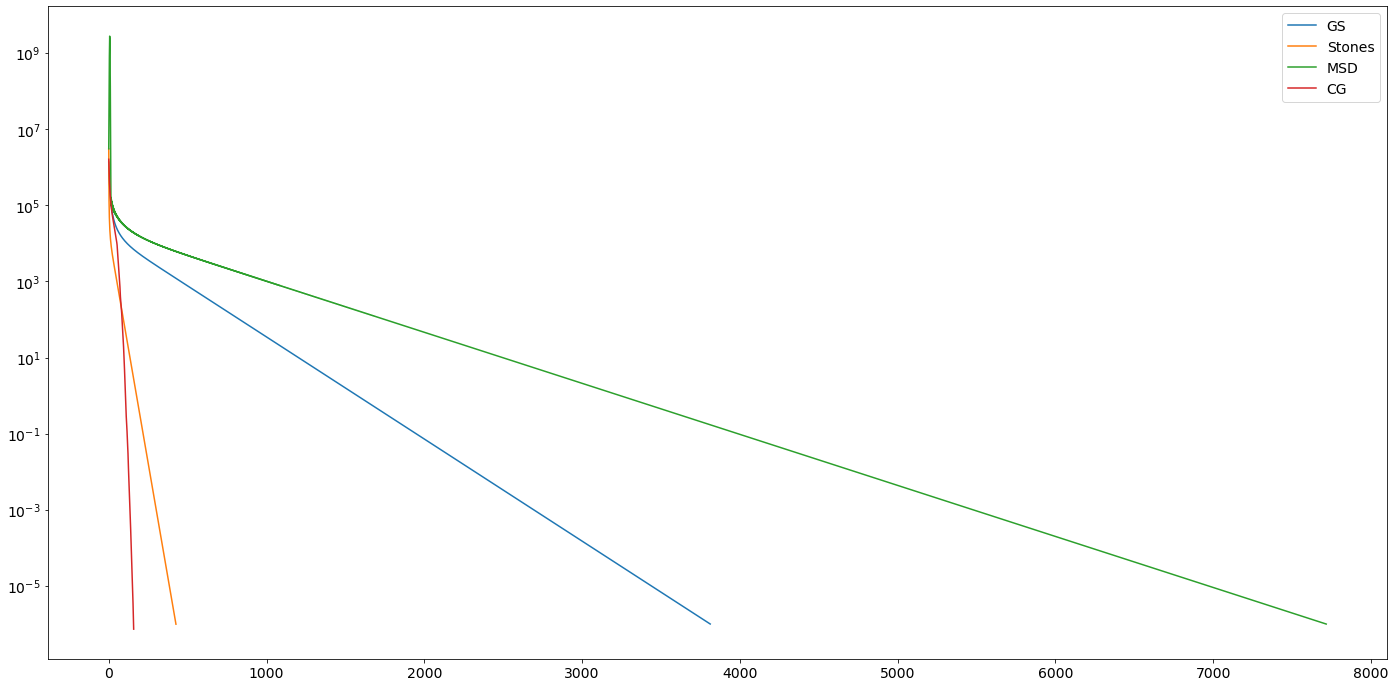

In [13]:
plt.figure(figsize=(24,12))
plt.plot(Rlogger_GS,label='GS')
# plt.plot(Rlogger_ADI,label='ADI')
plt.plot(Rlogger_Stone,label='Stones')
plt.plot(Rlogger_MSD,label='MSD')
plt.plot(Rlogger_CG,label='CG')
plt.yscale('log')
plt.legend()